In [1]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from collections import OrderedDict
import statistics

import warnings

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost import plot_importance

import shap

from expanding_window import expanding_window
from blockingtimeseriessplit import BlockingTimeSeriesSplit

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [3]:
masterfile_xl_file = pd.ExcelFile('/u/51/avonscha/unix/Desktop/Houston Analytics Pre-Assignment with data_English 3/Houston Analytics Pre-Assignment with data_English 3/output.xlsx')
masterfile_df = masterfile_xl_file.parse('Sheet1')

# AUTOMATICALLY MAKE LAG VARIABLES ALL ELSE THAN "COMPONENT LIFETIME"

In [4]:
lag_variables  = ['Sensor1', 'Sensor10', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16',
                  'Sensor17', 'Sensor18', 'Sensor19', 'Sensor2', 'Sensor20', 'Sensor21', 'Sensor22', 'Sensor23',
                  'Sensor24', 'Sensor25', 'Sensor26', 'Sensor27', 'Sensor28', 'Sensor29', 'Sensor3', 'Sensor30',
                  'Sensor31', 'Sensor32', 'Sensor33', 'Sensor34', 'Sensor37', 'Sensor38', 'Sensor39', 'Sensor4',
                  'Sensor40', 'Sensor41', 'Sensor43', 'Sensor44', 'Sensor45', 'Sensor46', 'Sensor47',
                  'Sensor48', 'Sensor49', 'Sensor5', 'Sensor50', 'Sensor51', 'Sensor52', 'Sensor53', 'Sensor6',
                  'Sensor7', 'Sensor8', 'Sensor9']

# How many hours 24 (1 day), 36 (1.5 day), 48 (2 days), 72 (3 days), 96 (4 days), 168 (7 days), 336 (14 days)
lags = [24, 36, 48, 72, 96, 168, 336]

masterfile_df = masterfile_df.assign(**{
    f'{col} (t-{lag})': masterfile_df[col].shift(lag)
    for lag in lags
    for col in lag_variables
})

sensor42_lags = [1, 2, 3, 4, 5, 6, 12, 24, 36, 48, 72, 96, 168, 336]

masterfile_df = masterfile_df.assign(**{
    f'{col} (t-{lag})': masterfile_df[col].shift(lag)
    for lag in sensor42_lags
    for col in ['Sensor42']
})

In [5]:
max(lags)

336

# AUTOMATICALLY DROP THE CURRENT SENSOR MEASUREMENTS BUT USE EVERYTHING ELSE

In [6]:
# Let us leave 2 weeks (24*14 hours) from the end for testing and remove 1 week from the beginning to fit lagged variables.
y = masterfile_df['Sensor42'] # dependent variable is the measurement of Sensor 42
X = masterfile_df.loc[:, (masterfile_df.columns != 'Sensor42') & (masterfile_df.columns != 'Date')]

# Drop the current values of other sensors from model features
X = X.drop(['Sensor1', 'Sensor10', 'Sensor11', 'Sensor12', 'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16',
            'Sensor17', 'Sensor18', 'Sensor19', 'Sensor2', 'Sensor20', 'Sensor21', 'Sensor22', 'Sensor23',
            'Sensor24', 'Sensor25', 'Sensor26', 'Sensor27', 'Sensor28', 'Sensor29', 'Sensor3', 'Sensor30',
            'Sensor31', 'Sensor32', 'Sensor33', 'Sensor34', 'Sensor37', 'Sensor38', 'Sensor39', 'Sensor4',
            'Sensor40', 'Sensor41', 'Sensor43', 'Sensor44', 'Sensor45', 'Sensor46', 'Sensor47',
            'Sensor48', 'Sensor49', 'Sensor5', 'Sensor50', 'Sensor51', 'Sensor52', 'Sensor53', 'Sensor6',
            'Sensor7', 'Sensor8', 'Sensor9'], axis=1)


# Train data (recall that some features are lagged)
y_train = y.loc[max(lags):len(y)-24*14]
X_train = X.loc[max(lags):len(y)-24*14,:]

# Test data
y_test = y.loc[len(y)-24*14:]
X_test = X.loc[len(y)-24*14:,:]

# MAYBE MORE FOLDS, BUT SMALLER PREDICTION WINDOW?

In [7]:
# Time series cross-validation with a walk forward approach
# Hyndman, R.J. & Athanasopoulos, G. (2018)
initial_train_len = 24*30 # one month
validation_set_len = 6 # half-a-day
increase_period = 6 # add a day to train set
tscv = expanding_window(initial = initial_train_len, horizon = int(validation_set_len), period = increase_period)

In [8]:
#btss = BlockingTimeSeriesSplit(n_splits=1)
#for train_index, test_index in btss.split(X_train):
#    print(train_index)
#    print(len(train_index))
#    print(test_index)
#    print(len(test_index))
#    print("\n")

In [9]:
n_short_folds = 0
for train_index, test_index in tscv.split(X_train):
    if len(test_index) < validation_set_len:
        n_short_folds += 1

In [10]:
# max_depth, min_child_weight and gamma are to optimize model complexity
# n_estimators is the number of decision trees
# learning_rate (eta), colsample_bytree are to optimize robustness
params={
        "n_estimators"     : [50, 100, 500, 1000],
        "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        "max_depth"        : [3, 4, 5, 6, 7, 10, 12, 15],
        "min_child_weight" : [1, 3, 5, 7],
        "gamma"            : [0, 1, 5, 10, 15, 25, 35],
        "colsample_bytree" : [0.3, 0.4, 0.5, 0.8],
        "subsample"        : [0.8, 0.9, 1]
        
}

model = xgb.XGBRegressor()

# param_distributions=params
# n_iter=10 => 10 parameter settings are sampled
# scoring => what metric to use as objective function, let's use accuracy
# n_jobs = 1 => no parallelism in optimization
# verbose=1 => only small amount of messages
# random_state = 1 => use same
# in the cross-validation, let us leave the last train&test set out, since the test set is very small

#random_search_initial = RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring='r2',n_jobs=1,
#                                           cv=btss.split(X_train),verbose=1, random_state=1)

if n_short_folds == 0:
    random_search_initial = RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring='r2',n_jobs=1,
                                               cv=tscv.split(X_train),verbose=1, random_state=1)
else:
    random_search_initial = RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring='r2',n_jobs=1,
                                          cv=tscv.split(X_train)[:-n_short_folds],verbose=1, random_state=1)
random_search_initial.fit(X_train, y_train)

Fitting 52 folds for each of 10 candidates, totalling 520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 520 out of 520 | elapsed: 26.3min finished


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [720, 721, 722, 723, 724, 725]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [726, 727, 728, 729, 730, 731]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [732, 733, 734...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                      

In [11]:
optimized_hyperparams_initial = random_search_initial.best_params_
random_search_initial.best_params_

{'subsample': 1,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 35,
 'colsample_bytree': 0.8}

In [12]:
optimized_model_initial = xgb.XGBRegressor(**optimized_hyperparams_initial)

In [13]:
optimized_model_initial.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=35, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Feature selection

In [14]:
# load JS visualization code to notebook
shap.initjs()

In [15]:
explainer = shap.TreeExplainer(optimized_model_initial)
shap_values = explainer.shap_values(X_train.loc[:, :])

Text(0.5, 0, 'Sensor 42 measurement')

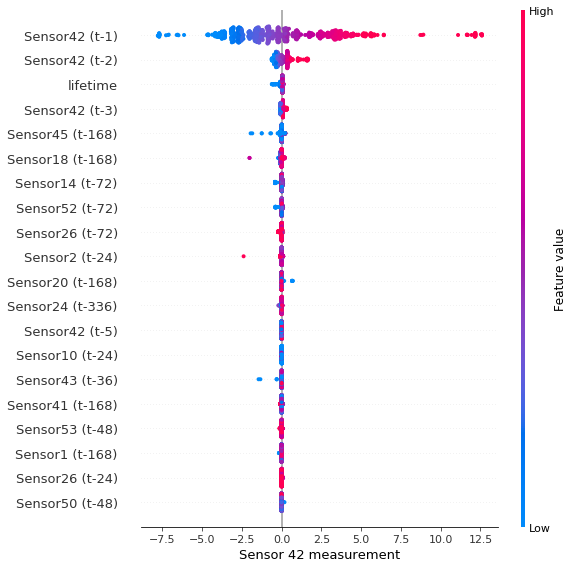

In [16]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_train.loc[:, :], show=False)
plt.xlabel('Sensor 42 measurement')

# Fit the model with 10 most important features

In [17]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

In [18]:
X_hat = masterfile_df[feature_importance.col_name.values[:10]]

# Train data (recall that some features are lagged 168 hours, or 24*7 hours)
X_hat_train = X_hat.loc[max(lags):len(y)-24*14,:]

# Test data
X_hat_test = X_hat.loc[len(y)-24*14:,:]

In [19]:
# max_depth, min_child_weight and gamma are to optimize model complexity
# n_estimators is the number of decision trees
# learning_rate (eta), colsample_bytree are to optimize robustness
params={
        "n_estimators"     : [50, 100, 500, 1000],
        "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        "max_depth"        : [3, 4, 5, 6, 7, 10, 12, 15],
        "min_child_weight" : [1, 3, 5, 7],
        "gamma"            : [0, 1, 5, 10, 15, 25, 35],
        "colsample_bytree" : [0.3, 0.4, 0.5, 0.8],
        "subsample"        : [0.8, 0.9, 1]
        
}

model = xgb.XGBRegressor()

# param_distributions=params
# n_iter=10 => 10 parameter settings are sampled
# scoring => what metric to use as objective function, let's use accuracy
# n_jobs = 1 => no parallelism in optimization
# cv = k-fold => leave-one-out crossvalidation
# verbose=1 => only small amount of messages
# random_state = 1 => use same

#random_search_final = RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring='r2',n_jobs=1,
#                                         cv=btss.split(X_train),verbose=1, random_state=1)
if n_short_folds == 0:
    random_search_final = RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring='r2',n_jobs=1,
                                             cv=tscv.split(X_hat_train),verbose=1, random_state=1)
else:
    random_search_final = RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring='r2',n_jobs=1,
                                             cv=tscv.split(X_hat_train)[:-n_short_folds],verbose=1, random_state=1)
random_search_final.fit(X_hat_train, y_train)

Fitting 52 folds for each of 10 candidates, totalling 520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 520 out of 520 | elapsed:  1.5min finished


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [720, 721, 722, 723, 724, 725]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [726, 727, 728, 729, 730, 731]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [732, 733, 734...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                      

In [20]:
random_search_final.best_params_

{'subsample': 1,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 35,
 'colsample_bytree': 0.8}

In [21]:
optimized_hyperparams_final = random_search_final.best_params_
#{'subsample': 1,
# 'n_estimators': 100,
# 'min_child_weight': 1,
# 'max_depth': 12,
# 'learning_rate': 0.05,
# 'gamma': 35,
# 'colsample_bytree': 0.8}

In [22]:
optimized_model_final = xgb.XGBRegressor(**optimized_hyperparams_final)

In [23]:
optimized_model_final.fit(X_hat_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=35, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

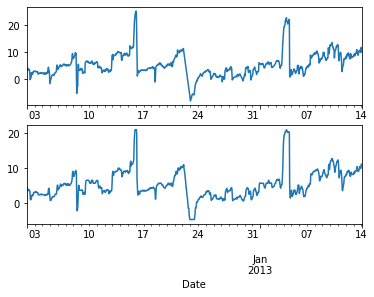

In [24]:
y_train_pred = optimized_model_final.predict(X_hat_train)

original_train = pd.Series(data=y_train.values, index=masterfile_df['Date'].loc[max(lags):len(y)-24*14])
predicted_train = pd.Series(data=y_train_pred, index=masterfile_df['Date'].loc[max(lags):len(y)-24*14])

fig, ax = plt.subplots(2)

original_train.plot(ax=ax[0])
predicted_train.plot(ax=ax[1])

plt.show()

# CROSS-VALIDATION

Cross-validation
MAPE:
0.05206940397002008


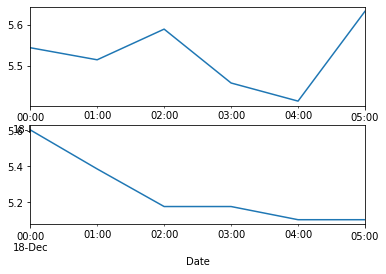

Cross-validation
MAPE:
0.0586981130917086


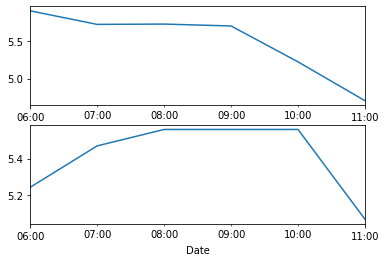

Cross-validation
MAPE:
0.10974289359180302


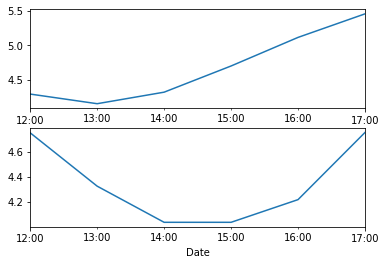

Cross-validation
MAPE:
0.0646901950234365


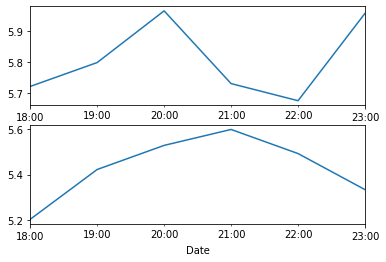

Cross-validation
MAPE:
0.055333318513318595


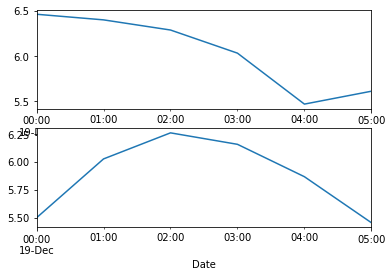

Cross-validation
MAPE:
0.09821932077501455


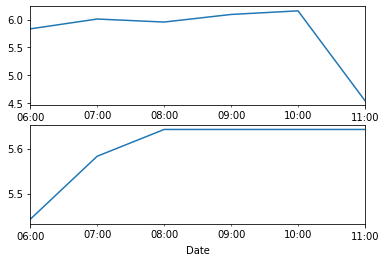

Cross-validation
MAPE:
0.06291984336456258


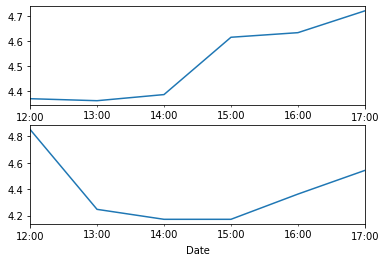

Cross-validation
MAPE:
0.0674702509881381


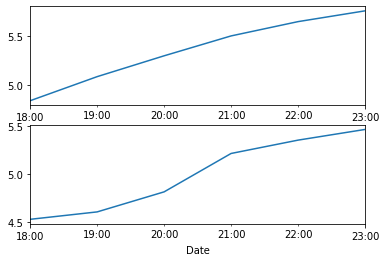

Cross-validation
MAPE:
0.05840690247242882


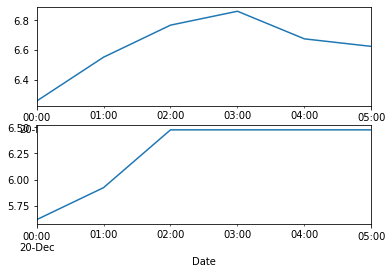

Cross-validation
MAPE:
0.036084153430753226


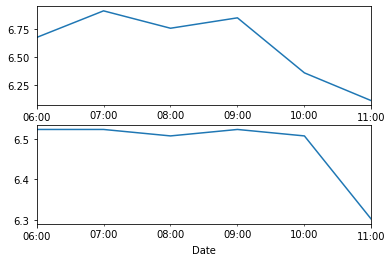

Cross-validation
MAPE:
0.12771164555478562


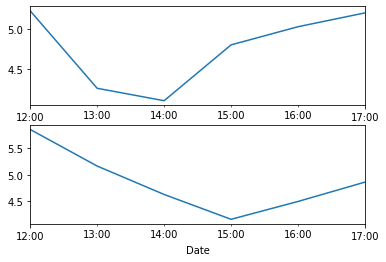

Cross-validation
MAPE:
0.23493604085164155


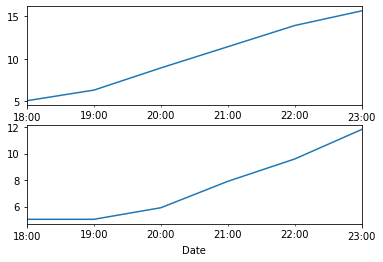

Cross-validation
MAPE:
0.05902043092584694


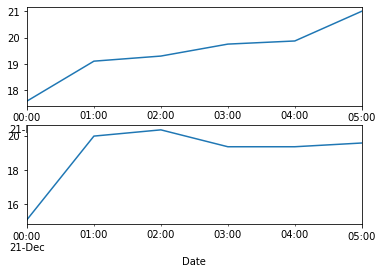

Cross-validation
MAPE:
0.039435316619552116


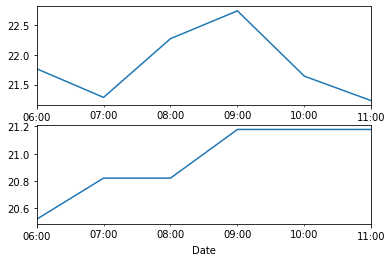

Cross-validation
MAPE:
0.023373673386343576


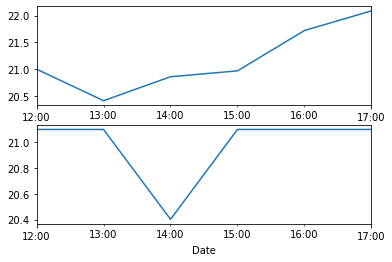

Cross-validation
MAPE:
3.5969587837226


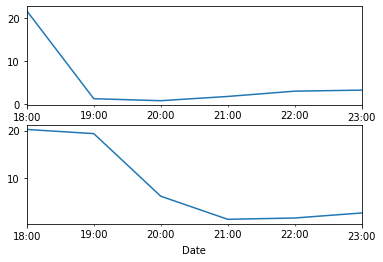

Cross-validation
MAPE:
0.3291836624373638


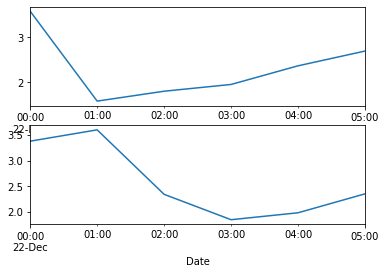

Cross-validation
MAPE:
0.08704725603915792


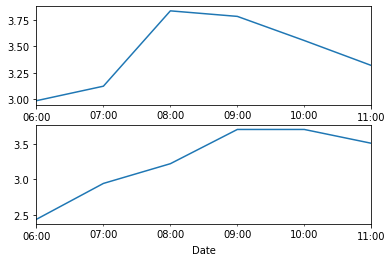

Cross-validation
MAPE:
0.14068236663999986


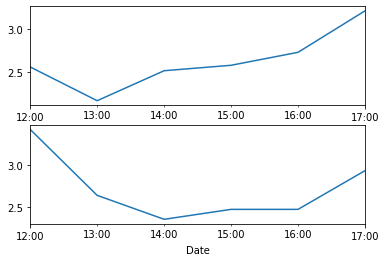

Cross-validation
MAPE:
0.1252455770302157


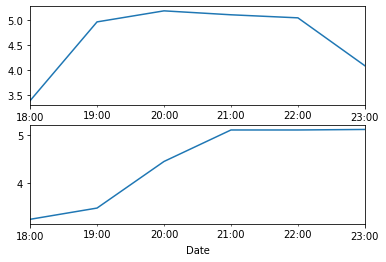

Cross-validation
MAPE:
0.36668817200359866


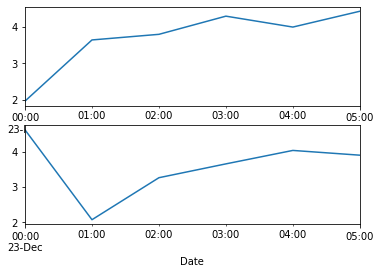

Cross-validation
MAPE:
0.09667528690881483


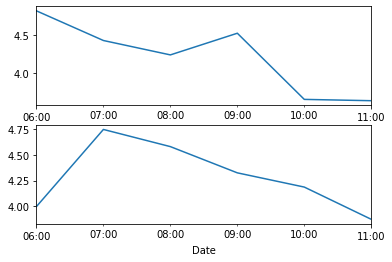

Cross-validation
MAPE:
0.4231625516466259


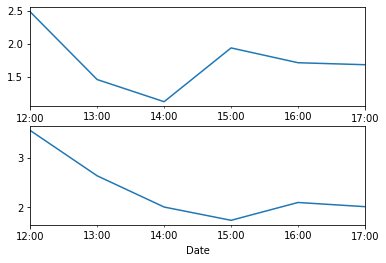

Cross-validation
MAPE:
0.13629884743609277


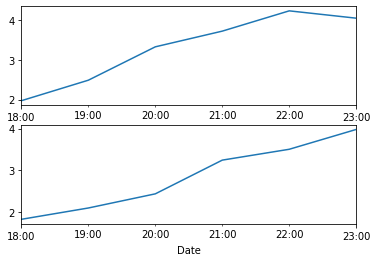

Cross-validation
MAPE:
0.07735771873324172


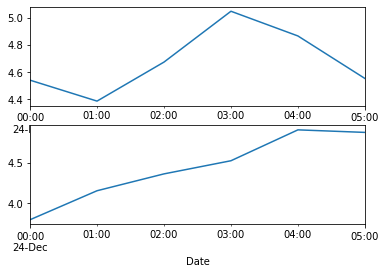

Cross-validation
MAPE:
0.1219748862524818


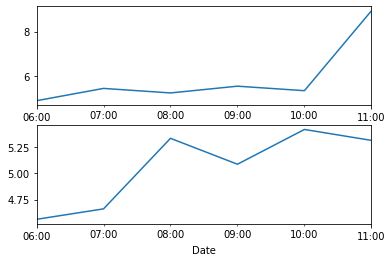

Cross-validation
MAPE:
0.042983785249700555


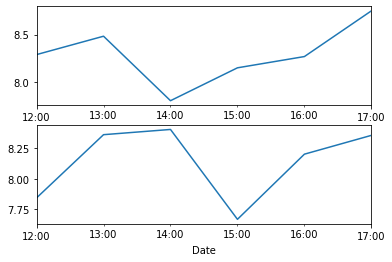

Cross-validation
MAPE:
0.04060977349759535


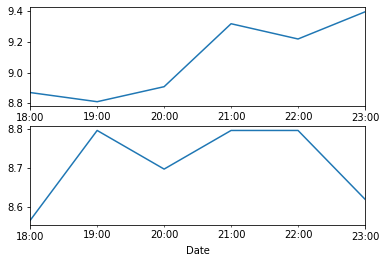

Cross-validation
MAPE:
0.0840058849226546


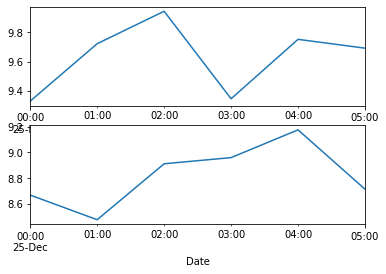

Cross-validation
MAPE:
0.0490027779460197


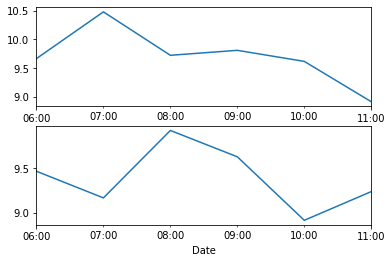

Cross-validation
MAPE:
0.12880860745725523


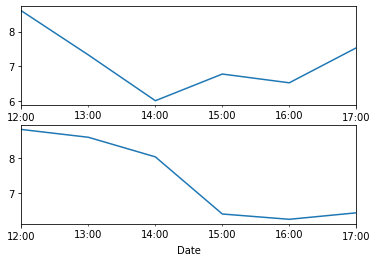

Cross-validation
MAPE:
0.035952019190826724


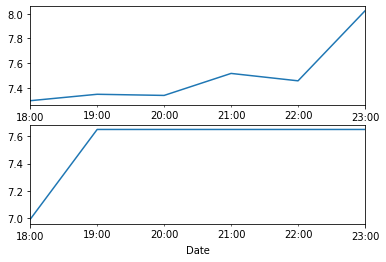

Cross-validation
MAPE:
0.06614712213632436


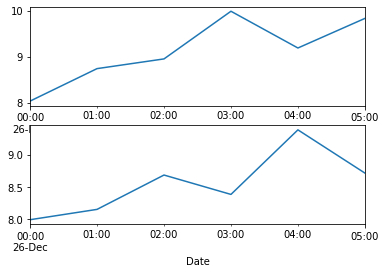

Cross-validation
MAPE:
0.0558702994329754


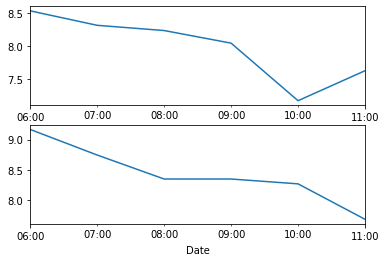

Cross-validation
MAPE:
0.03932731034249401


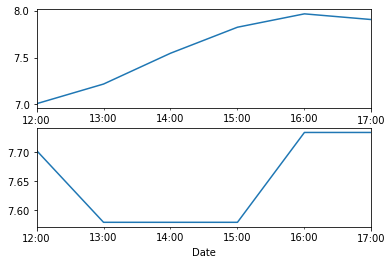

Cross-validation
MAPE:
0.16484247822425716


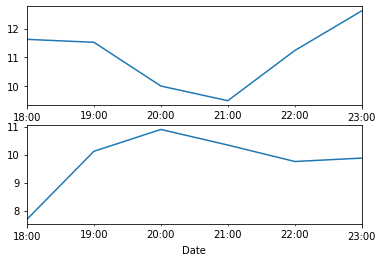

Cross-validation
MAPE:
0.08697844893139113


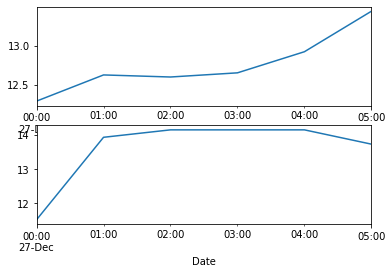

Cross-validation
MAPE:
0.14247511125514134


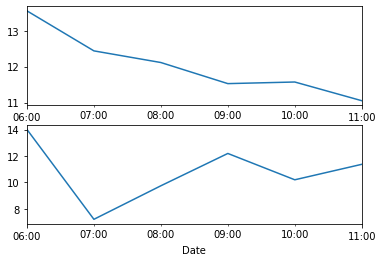

Cross-validation
MAPE:
0.11001602860269898


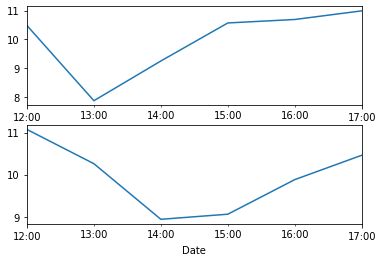

Cross-validation
MAPE:
0.05021418775360873


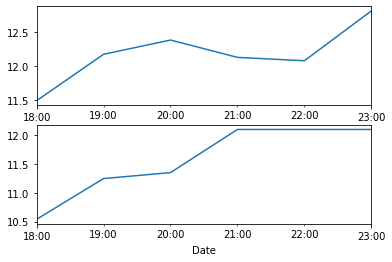

Cross-validation
MAPE:
0.16375943333743068


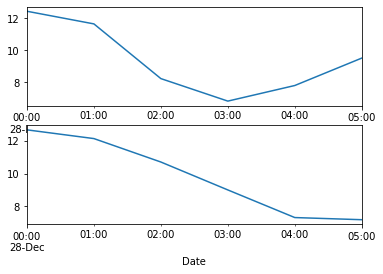

Cross-validation
MAPE:
0.11510562836059542


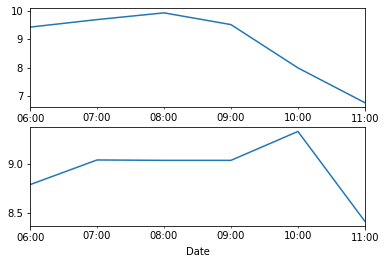

Cross-validation
MAPE:
0.38033072030918996


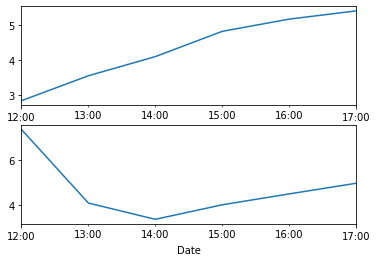

Cross-validation
MAPE:
0.07973785088131584


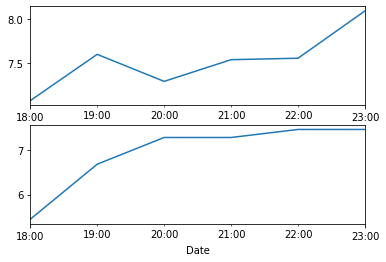

Cross-validation
MAPE:
0.05068395934431344


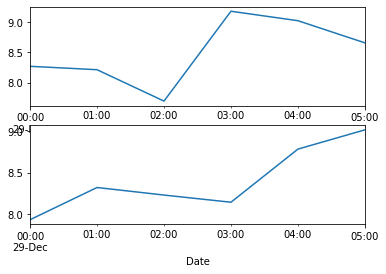

Cross-validation
MAPE:
0.0479936953183106


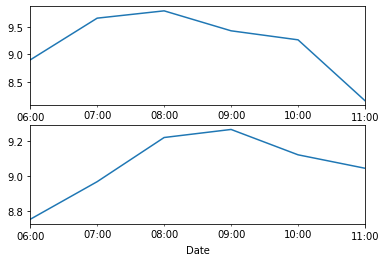

Cross-validation
MAPE:
0.07757378060626552


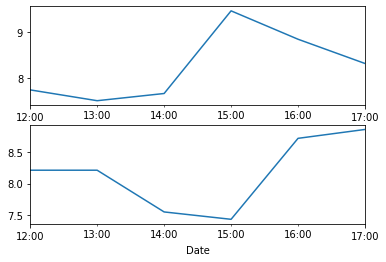

Cross-validation
MAPE:
0.048150527710930015


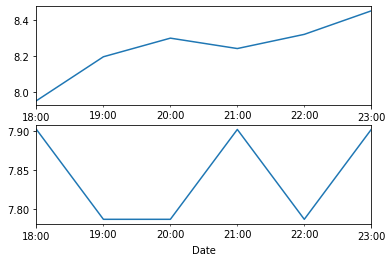

Cross-validation
MAPE:
0.053555462098879215


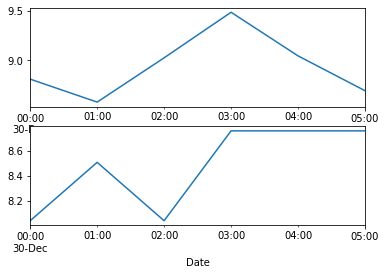

Cross-validation
MAPE:
0.09702361701612962


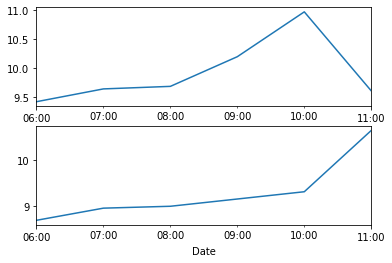

Cross-validation
MAPE:
0.05654399840272758


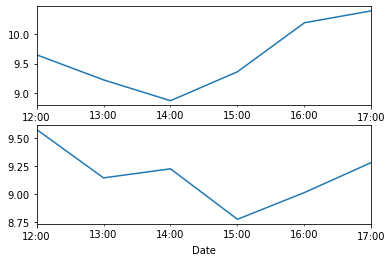

Cross-validation
MAPE:
0.05422908677261699


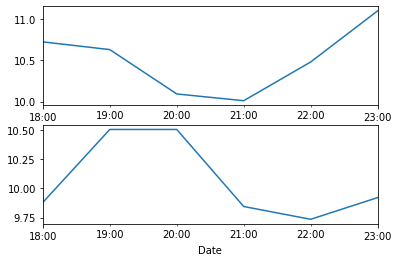

In [25]:
y_predictions = []
y_realizations = []

# Let us leave the last train&test set out, since the test set is too small
#for train_index, test_index in btss.split(X_hat_train):
for train_index, test_index in tscv.split(X_hat_train)[:-n_short_folds]:

    X_train_, X_val = X_hat_train.iloc[train_index], X_hat_train.iloc[test_index]
    y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    
    # Use the model already fitted with the whole data set(?) 
    optimized_model_final.fit(X_train_, y_train_)
    y_pred = optimized_model_final.predict(X_val)
  
    # Save y realizations for hold-out-fold
    y_realizations.extend(y_val.values)

    # Save y predictions for hold-out-fold
    y_predictions.extend(y_pred)
      
    print('Cross-validation')
    #print('R2:')
    #print(r2_score(y_val.values, y_pred))
    #print('MAE:')
    #print(mean_absolute_error(y_val.values, y_pred))
    #print('MSE:')
    #print(mean_squared_error(y_val.values, y_pred))
    #print('\n')
    
    print('MAPE:')
    print(mean_absolute_percentage_error(y_val.values, y_pred))
    
    #print(y_val.values)
    #print(y_pred)
    val_original_train = pd.Series(data=y_val.values, index=masterfile_df['Date'].loc[test_index[0]:test_index[-1]])
    val_predicted_train = pd.Series(data=y_pred, index=masterfile_df['Date'].loc[test_index[0]:test_index[-1]])

    fig, ax = plt.subplots(2)

    val_original_train.plot(ax=ax[0])
    val_predicted_train.plot(ax=ax[1])

    plt.show()
       
#print('Cross-validation')
#print('R2:')
#print(r2_score(y_realizations, y_predictions))
#print('MAE:')
#print(mean_absolute_error(y_realizations, y_predictions))
#print('MSE:')
#print(mean_squared_error(y_realizations, y_predictions))

In [26]:
# After cross-validation refit the model to the whole training data set
optimized_model_final.fit(X_hat_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=35, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Test

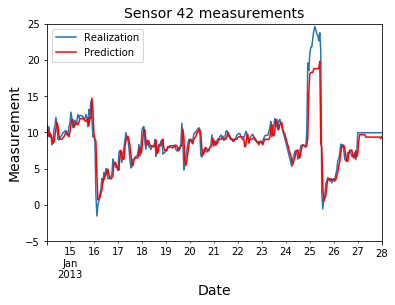

In [27]:
y_test_pred = optimized_model_final.predict(X_hat_test)

original_test = pd.Series(data=y_test.values, index=masterfile_df['Date'].loc[len(y)-24*14:])
predicted_test = pd.Series(data=y_test_pred, index=masterfile_df['Date'].loc[len(y)-24*14:])

fig, ax = plt.subplots()

original_test.plot(ax=ax, label="Realization")
predicted_test.plot(ax=ax, color='red', label='Prediction')
plt.title('Sensor 42 measurements', fontsize=14)
plt.ylim([-5,25])
plt.xlabel("Date", fontsize=14)
plt.ylabel("Measurement", fontsize=14)
plt.legend()

plt.show()

In [28]:
print('MAPE:')
print(mean_absolute_percentage_error(y_test.values, y_test_pred))

MAPE:
0.17536330506397477


Text(0.5, 0, 'Sensor 42 measurement')

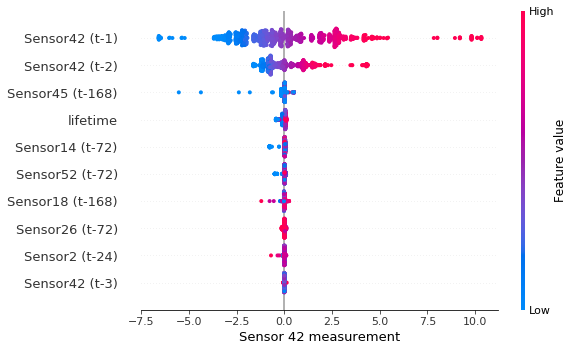

In [30]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(optimized_model_final)
shap_values = explainer.shap_values(X_hat_train.loc[:, :])

fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_hat_train.loc[:, :], show=False)
plt.xlabel('Sensor 42 measurement')